# Anticipez les besoins en consommation électrique de bâtiments

- **Projet 4 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 2 : Modélisation et Résultats

<img height="64" src="https://user.oc-static.com/upload/2019/02/24/15510245026714_Seattle_logo_landscape_blue-black.png" alt="Logo seattle">


## 1.1 Mission

À partir des [relevés déjà réalisés en 2015 et 2016](https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv) :

- **prédire les émissions de CO2** et la **consommation totale d’énergie** de bâtiments commerciales en Seattle pour lesquels elles n’ont pas encore été mesurées, basé sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction ...).

- **évaluer l’intérêt de l’[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what) pour la prédiction d’émissions**.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook


### 1.2.1 Import des bibliothèques


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
# import sklearn


### 1.2.2 Liste des versions des bibliothèques utilisées


In [2]:
from platform import python_version
python_version()

print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3


### 1.2.3 Configuration défauts d'affichage


In [3]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
# pd.set_option('display.precision', 2)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


## 1.3 Des fonctions utilitaires

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [4]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


def to_png(fig_name=None):
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """
    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(
            ':', '-').replace('.', '-').replace('/', '_')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [5]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


## 1.4 Les métriques d'évaluation


In [6]:
from sklearn.metrics import SCORERS

print(list(SCORERS))


['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']


Pour la régression linéaire, les métriques pour estimer les erreurs entre y_pred et y_test sont:

- R2 (Coefficient )
- neg_mean_squared_error
- neg


In [7]:
from sklearn import metrics


def performance_metrics(y_true, y_pred):
    meas = metrics._regression
    ret = dict(
        R2=metrics.r2_score(y_true, y_pred),
        MSE=metrics._regression.mean_squared_error(y_true, y_pred),
        RMSE=np.sqrt(metrics._regression.mean_squared_error(y_true, y_pred)),
        # MSLE=metrics._regression.mean_squared_log_error(y_true, y_pred),
        # RMSLE=np.sqrt(
        #     metrics._regression.mean_squared_log_error(y_true, y_pred)),
    )
    return ret


performance_metrics([1, 2, 3], [8, 3, 2])


{'R2': -24.5, 'MSE': 17.0, 'RMSE': 4.123105625617661}

### Visualise le valeurs prédites vs actuelles


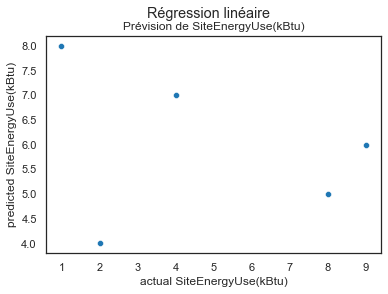

In [8]:
def plot_predict_vs_actual(y_true=[1, 2, 3], y_pred=[1, 2, 3], hue=None,
                           target_feature='SiteEnergyUse(kBtu)', titre=''):

    # fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    # plt.figure(figsize=(10,10))
    ax = plt.subplot(1, 1, 1)
    sns.scatterplot(x=y_true, y=y_pred, hue=hue, legend=None, ax=ax)
    if not (isinstance(y_true[0], str)):
        r2 = metrics.r2_score(y_true, y_pred)
        ax.annotate(f'R2 = {r2:.3f}', xy=(-15, 20))
    # plt.text(f'R2 = {r2:.3f}',xy=(0,0.9))
    ax.set_xlabel(f'actual {target_feature}')
    ax.set_ylabel(f'predicted {target_feature}')
    ax.set_title(f'Prévision de {target_feature}')
    if not hue is None:
        plt.legend(labels=hue)
    plt.suptitle(titre)
    # ax=ax=plt.subplot(1,2,2)
    # Plot the original distribution
    # sns.kdeplot(pd.DataFrame(y_test).astype(float), label='Original Distribution', ax=ax)
    # sns.kdeplot(pd.DataFrame(y_pred).astype(float), label='Predicted Distribution',ax=ax)
    # plt.legend(labels=['original', 'predicted'])
    # ax.set_xlabel(feature)
    # ax.set_ylabel('')


plot_predict_vs_actual([1, 2, 4, 8, 9], [8, 4, 7, 5, 6],
                       titre='Régression linéaire')


### Analyse de residuels


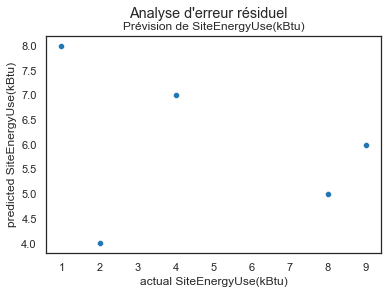

In [9]:
def plot_residuals(y_true, y_pred, target_feature='SiteEnergyUse(kBtu)', titre=None):
    residuals = y_true - y_pred
    ax = plt.subplot(1, 1, 1)
    sns.scatterplot(x=y_true, y=residuals, legend=None, ax=ax)
    if not (isinstance(y_true[0], str)):
        r2 = metrics.r2_score(y_true, residuals)
        ax.annotate(f'R2 = {r2:.3f}', xy=(-15, 20))
    # plt.text(f'R2 = {r2:.3f}',xy=(0,0.9))
    ax.set_xlabel(f'actual {target_feature}')
    ax.set_ylabel(f'predicted {target_feature}')
    ax.set_title(f'Prévision de {target_feature}')
    plt.suptitle(titre)


plot_predict_vs_actual([1, 2, 4, 8, 9], [8, 4, 7, 5, 6],
                       titre="Analyse d'erreur résiduel")


# 2. Données d'entrainement et test


## Import des données nettoyées


In [10]:
model_df = pd.read_csv('data/out/cleaned_data.csv')
model_df.head()


,OSEBuildingID,DataYear,NumberofFloors,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,ZipCode,PrimaryUseType,building_age,area_per_floor,percent_parking,distance(km)
0,1,2015,12.0,88434.0,65.0,6981428.0,249.43,98101,hotel-like,95,7369.500000,0.000000,0.556751
1,2,2015,11.0,83880.0,51.0,8354235.0,263.51,98101,hotel-like,26,8045.636364,0.145453,0.354915
2,3,2015,41.0,757243.0,18.0,73130656.0,2061.48,98101,hotel-like,53,23463.170732,0.000000,0.442002
3,5,2015,10.0,61320.0,1.0,28229320.0,1936.34,98101,hotel-like,96,6132.000000,0.000000,0.315723
4,8,2015,18.0,123445.0,67.0,14829099.0,507.70,98121,hotel-like,42,5968.333333,0.103929,0.608448


### Vérification que toutes les colonnes sont 100% remplies


In [11]:
model_df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              2986 non-null   int64  
 1   DataYear                   2986 non-null   int64  
 2   NumberofFloors             2986 non-null   float64
 3   LargestPropertyUseTypeGFA  2986 non-null   float64
 4   ENERGYSTARScore            1990 non-null   float64
 5   SiteEnergyUse(kBtu)        2986 non-null   float64
 6   TotalGHGEmissions          2986 non-null   float64
 7   ZipCode                    2986 non-null   int64  
 8   PrimaryUseType             2986 non-null   object 
 9   building_age               2986 non-null   int64  
 10  area_per_floor             2986 non-null   float64
 11  percent_parking            2986 non-null   float64
 12  distance(km)               2986 non-null   float64
dtypes: float64(8), int64(4), object(1)
memory usage:

In [12]:
model_df['ENERGYSTARScore'].isna().sum()/len(model_df)


0.333556597454789

On voit que toutes les colonnes sont 100% non_null, sauf ENERGYSTARScore (1990 de 2986 valeurs remplis)

L'ENERGYSTARScore est applicable seulement pour 21 des plus de 80 PropertyTypes, donc cette colonne n'est pas 100% remplie. Pour la première partie de la modélisation, on n'utilise pas cette colonne pour les prévisions.

- Imputer l'ENERGYSTARScore pour les autres PropertyTypes n'a aucun sense, car c'est un ranking parmi les bâtiments de la même PropertyType dans tout le pays

- On évaluera plus tard l'utilité de cette colonne seulement pour les PropertyTypes ou il est présent, en excluant les lignes ou ce n'est pas présent


### Corriger datatypes

Certains champs numériques sont catégoriques (ZipCode, DataYear), ou identifiants des bâtiments (OSEBuildingID) :

- **DataYear** et **ZipCode**ZipCode sont potentiellement des variables catégoriques à inclure dans les modèles
- **OSEBuildingID** sera utilisé pour analyser et interpréter les erreurs des prédictions, mais ce champ n'est pas utilisé dans la modélisation

On les convertit en type 'object'


In [13]:
object_cols = ['DataYear', 'ZipCode', 'OSEBuildingID']


def corriger_datatypes(df, obj_cols=object_cols):
    df = df.copy()
    for col in obj_cols:
        if col in df:
            df[col] = df[col].astype('object')
    return df


model_df = model_df.pipe(corriger_datatypes)
model_df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2986 entries, 0 to 2985
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              2986 non-null   object 
 1   DataYear                   2986 non-null   object 
 2   NumberofFloors             2986 non-null   float64
 3   LargestPropertyUseTypeGFA  2986 non-null   float64
 4   ENERGYSTARScore            1990 non-null   float64
 5   SiteEnergyUse(kBtu)        2986 non-null   float64
 6   TotalGHGEmissions          2986 non-null   float64
 7   ZipCode                    2986 non-null   object 
 8   PrimaryUseType             2986 non-null   object 
 9   building_age               2986 non-null   int64  
 10  area_per_floor             2986 non-null   float64
 11  percent_parking            2986 non-null   float64
 12  distance(km)               2986 non-null   float64
dtypes: float64(8), int64(1), object(4)
memory usage:

## Choix de variables independents (X) et la variable à prédire (y)

On va créer plusieurs modèles prenant compte de différents variables independents, pour prédire soit consommation énergétique, soit les emissions CO2. Ci-dessous, une fonction pour simplifier le tâche


In [14]:
print(model_df.columns.tolist())


['OSEBuildingID', 'DataYear', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'ZipCode', 'PrimaryUseType', 'building_age', 'area_per_floor', 'percent_parking', 'distance(km)']


In [15]:
colonnes_x = ['DataYear', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'ZipCode', 'ENERGYSTARScore',
              'PrimaryUseType', 'building_age', 'area_per_floor', 'percent_parking', 'distance(km)']

colonnes_cibles = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']


def create_x_y(df, cols_x=colonnes_x, col_y=colonnes_cibles):
    cols_x = cols_in_df(df, cols_x)
    print(f'create_x_y, y={col_y}, x={cols_x}')
    return df[cols_x], df[col_y]


bldg_id = model_df[['OSEBuildingID']]
x, y = model_df.pipe(create_x_y)
print(x.shape)
print(y.shape)


create_x_y, y=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], x=['DataYear', 'NumberofFloors', 'LargestPropertyUseTypeGFA', 'ZipCode', 'ENERGYSTARScore', 'PrimaryUseType', 'building_age', 'area_per_floor', 'percent_parking', 'distance(km)']
(2986, 10)
(2986, 2)


## Division en jeux de données d'entraînement et de test

Avant d'encoder les variables catégoriques, et normaliser les variables, il faut diviser entre données d'entrainement et test, pour éviter 'data leakage' :

- Pour prédire la consommation énergétique de nouveaux bâtiments, on ne peut pas savoir en avance leur taille, PrimaryUsageType, année de construction, localisation, etc
- On utilise les jeux de données test pour simuler ces nouveaux bâtiments : les modèles ne doit pas avoir connaissance de ces données pour améliorer ces prédictions (par exemple, via cross-validation)
- Les performances des modèles seront évalués versus ce jeu de 'test'

Pour division entre données d'entrainement et test, on a plusieurs stratégies :

- une division aléatoire (ex 80% entrainement, 20% test) : Mais on risque de mettre beaucoup de créer de bias dans le jeu d'entrainement si il n'est pas répresentatif de les différent types d'usage de propriété (exemple, si les données d'entrainement contiennent peu d'hopitaux oumanque de data center, ou la consommation énergetique est plus important)

- stratification : Essayer de garantie que le jeu de données d'entrainement ont le même distribution par consommation énergétique, ou par property usage, ou par localisation (ZipCode), ou distance du centre, ou par superficie, etc


### Stratification

Pour éviter bias sampling, on essaie de garder les mêmes distributions dans le jeu d'entrainement que dans les données, en supposant que l'echantillon de données fournies sont répresentative de la population de bâtiments à prédireS.

Il y a potentiellement beaucoup d'options de stratification à tester (autant que variables independents, si on crée des 'bins' pour les variables numériques)

Potentiellement la variable la plus importante à stratifier sera par type d'usage, car l'analyse exploratoire a montré que la consommation énergétique est fortement corrélé avec **'PrimaryUseType'**

Utilisant cette stratégie de stratification on attend que les petites, moyennes et grandes consommations énergétiques dans le jeu de données d'entrainement et test sont distribués également entre les jeux de données train et test

#### Références

- <https://scikit-learn.org/stable/common_pitfalls.html#data-leakage>
- <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>
- <https://towardsdatascience.com/how-to-master-the-subtle-art-of-train-test-set-generation-7a8408bcd578>


In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=x['PrimaryUseType'], random_state=1)


Verification que la stratification a produit l'effet désiré :


In [17]:
x_train_describe = x_train.describe()
x_train_describe['groupe'] = 'x_train'
x_test_describe = x_test.describe()
x_test_describe['groupe'] = 'x_test'
pd.concat([x_train_describe, x_test_describe], axis=0).pivot(columns='groupe')


NumberofFloors              LargestPropertyUseTypeGFA                \
groupe         x_test      x_train                    x_test       x_train   
25%          1.000000     1.000000              2.424400e+04  2.552100e+04   
50%          2.000000     2.000000              4.310200e+04  4.219000e+04   
75%          4.000000     4.000000              8.964775e+04  8.854200e+04   
count      598.000000  2388.000000              5.980000e+02  2.388000e+03   
max         63.000000    99.000000              1.719643e+06  1.719643e+06   
mean         4.158863     4.258375              9.160660e+04  9.124849e+04   
min          1.000000     1.000000              6.455000e+03  5.656000e+03   
std          6.610472     6.777127              1.582482e+05  1.608813e+05   

       ENERGYSTARScore              building_age              area_per_floor  \
groupe          x_test      x_train       x_test      x_train         x_test   
25%          43.000000    46.000000    32.000000    34.000000   1.322495e+04   
50%          74.000000    71.000000    57.000000    57.000000   2.171800e+04   
75%          89.000000    88.000000    92.000000    93.000000   3.370088e+04   
count       400.000000  1590.000000   598.000000  2388.000000   5.980000e+02   
max         100.000000   100.000000   122.000000   122.000000   1.100000e+06   
mean         64.497500    63.867296    60.244147    60.902429   3.270004e+04   
min           1.000000     1.000000     8.000000     8.000000   4.456000e+03   
std          29.017668    28.446509    32.940390    32.595323   5.852689e+04   

                     percent_parking              distance(km)               
groupe       x_train          x_test      x_train       x_test      x_train  
25%     1.192150e+04        0.000000     0.000000     1.373083     1.411373  
50%     2.054479e+04        0.000000     0.000000     3.855126     3.797064  
75%     3.300500e+04        0.000000     0.000000     6.777894     6.737987  
count   2.388000e+03      598.000000  2388.000000   598.000000  2388.000000  
max     1.100000e+06        0.771173     0.895023    12.859119    13.139924  
mean    3.124049e+04        0.062952     0.064747     4.467345     4.438553  
min     2.216970e+02        0.000000     0.000000     0.135912     0.057431  
std     4.473823e+04        0.140384     0.141457     3.465349     3.376052

Les distributions des variables en x_train et x_test semble approximativement similaire.

On voit si les consommations énergétiques sont distribués de la même façon :


In [18]:
y_train_describe = y_train.describe()
y_train_describe['groupe'] = 'y_train'
y_test_describe = y_test.describe()
y_test_describe['groupe'] = 'y_test'
pd.concat([y_train_describe, y_test_describe], axis=0).pivot(columns='groupe')


SiteEnergyUse(kBtu)               TotalGHGEmissions              
groupe              y_test       y_train            y_test       y_train
25%           1.276316e+06  1.227076e+06         18.920000     19.972500
50%           2.490546e+06  2.615611e+06         48.300000     49.215000
75%           6.802188e+06  7.005158e+06        138.745000    137.942500
count         5.980000e+02  2.388000e+03        598.000000   2388.000000
max           1.434230e+08  2.958126e+08       4906.330000  12307.160000
mean          7.236200e+06  7.776629e+06        142.612107    173.646796
min           4.394300e+04  1.715000e+04          0.310000      0.120000
std           1.468593e+07  1.986626e+07        367.394369    612.774864

Les distributions des variables en y_train et y_test semble approximativement similaire, mais le moyenne et l'écart type sont très influencés par les grands consommateurs d'énergie ('outliers').


## Preprocessing

- des variables catégoriques
- des variables numériques
- des variables cibles (y)

Le but de preprocessing est d'appliqué les mêmes transformations sur les données train, test, et des nouveaux bâtiments quand il faut les prédire.

Si on veut que les modèles marche aussi pour les nouveaux bâtiments, il faut que les procédures de processing sont robustes à des valeurs manquantes, et des nouvelles catégories.


In [19]:
category_features = x.select_dtypes(exclude='number').columns.tolist()
numerical_features = x.select_dtypes(include='number').columns.tolist()
target_features = y.columns.tolist()

print(f'numerical_features : {numerical_features}')
print(f'category_features : {category_features}')
print(f'target_features : {target_features}')


numerical_features : ['NumberofFloors', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'building_age', 'area_per_floor', 'percent_parking', 'distance(km)']
category_features : ['DataYear', 'ZipCode', 'PrimaryUseType']
target_features : ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']


### Preprocessing des variables catégoriques

Les algorithmes de machine learning nécessitent des valeurs numériques en entrée.

Les variables de type d'usage peuvent être transformés via pd.get_dummies ou via sklearn.preprocessing.OneHotEncoder

En utilisant stratification avec'PrimaryUseType', on est garanti que tous les categories de 'PrimaryUseType' sont répresentés dans x_train et y_train :


In [20]:
print(model_df['PrimaryUseType'].nunique())
print(x_train['PrimaryUseType'].nunique())
print(x_test['PrimaryUseType'].nunique())
pd.get_dummies(x_train['PrimaryUseType']).head()


11
11
11


,campus,distribution center,hospital,hotel-like,large office,medium office,other,residence,school,shops,unheated
2073,1,0,0,0,0,0,0,0,0,0,0
2608,0,0,0,0,0,0,0,0,0,0,1
820,0,0,0,0,0,0,1,0,0,0,0
1827,0,0,0,0,0,0,0,0,0,1,0
1949,0,0,0,0,1,0,0,0,0,0,0


Dans ce cas, le résultat de pd.get_dummies et OneHotEncoder doit être la même:


In [21]:
def flatten(t):
    """List of lists --> list"""
    return [item for sublist in t for item in sublist]


In [22]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype='int')
ohe_train = ohe.fit_transform(x_train[['PrimaryUseType']])

# noms de colonnes sans préfixe de la colonne originale
ohe_columns = flatten(ohe.categories_)

# noms de colonnes avec préfixe de la colonne originale
ohe_cols = ohe.get_feature_names_out(['PrimaryUseType'])
print(ohe_cols)

ohe_test = ohe.transform(x_test[['PrimaryUseType']])
ohe_test_df = pd.DataFrame(ohe_test, index=x_test.index,
                           columns=ohe_columns)
ohe_test_df.head()


['PrimaryUseType_campus' 'PrimaryUseType_distribution center'
 'PrimaryUseType_hospital' 'PrimaryUseType_hotel-like'
 'PrimaryUseType_large office' 'PrimaryUseType_medium office'
 'PrimaryUseType_other' 'PrimaryUseType_residence' 'PrimaryUseType_school'
 'PrimaryUseType_shops' 'PrimaryUseType_unheated']


,campus,distribution center,hospital,hotel-like,large office,medium office,other,residence,school,shops,unheated
21,0,0,0,0,0,0,1,0,0,0,0
758,0,0,0,0,0,0,1,0,0,0,0
483,0,0,0,0,0,0,0,0,0,0,1
10,0,0,0,1,0,0,0,0,0,0,0
1385,0,0,0,0,0,0,0,0,0,0,1


Mais si on a des autres colonnes catégoriques ou les catégories dans le test set qui ne sont pas dans le train set ou vice_versa, pd.get_dummies rendre un nombre de variables différents pour x_train et x_test, et le modèle ne marchera pas.


In [23]:
print(pd.get_dummies(x_train['ZipCode']).shape[1])
print(pd.get_dummies(x_test['ZipCode']).shape[1])


42
32


Donc, il est préferable d'utiliser OneHotEncoder pour transformer tous les colonnes categoriques


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

category_features = x_train.select_dtypes(exclude='number').columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_train = ohe.fit_transform(x_train[category_features])
ohe_test = ohe.transform(x_test[category_features])

ohe_test_df = pd.DataFrame(ohe_test, index=x_test.index,
                           columns=ohe.get_feature_names_out(category_features))

ohe_test_df.head()


,DataYear_2015,DataYear_2016,ZipCode_98006,ZipCode_98011,ZipCode_98013,ZipCode_98020,ZipCode_98033,ZipCode_98053,ZipCode_98101,ZipCode_98102,ZipCode_98103,ZipCode_98104,ZipCode_98105,ZipCode_98106,ZipCode_98107,ZipCode_98108,ZipCode_98109,ZipCode_98111,ZipCode_98112,ZipCode_98113,ZipCode_98115,ZipCode_98116,ZipCode_98117,ZipCode_98118,ZipCode_98119,ZipCode_98121,ZipCode_98122,ZipCode_98124,ZipCode_98125,ZipCode_98126,ZipCode_98133,ZipCode_98134,ZipCode_98136,ZipCode_98144,ZipCode_98145,ZipCode_98146,ZipCode_98154,ZipCode_98155,ZipCode_98165,ZipCode_98177,ZipCode_98178,ZipCode_98181,ZipCode_98191,ZipCode_98199,PrimaryUseType_campus,PrimaryUseType_distribution center,PrimaryUseType_hospital,PrimaryUseType_hotel-like,PrimaryUseType_large office,PrimaryUseType_medium office,PrimaryUseType_other,PrimaryUseType_residence,PrimaryUseType_school,PrimaryUseType_shops,PrimaryUseType_unheated
21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
758,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
483,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Preprocessing des variables numériques

- imputation des valeurs manquantes
- normalisation des distributions pour réduire l'influence d'outliers dans chaque variable
- scaling des variables pour accélerer le descente de gradiente et faire que chaque variable a un influence similaire sur les érreurs residuels.


#### Imputation des valeurs manquantes

- Utilise la médiane pour être moins influencé par les outliers


In [25]:
from IPython.display import display
from sklearn.impute import SimpleImputer


def impute_columns(df, cols=None, imputer: SimpleImputer = None, strategy='median'):
    df = df.copy()
    if cols is None:
        cols = df.select_dtypes('number').columns
    if imputer is None:
        imputer = SimpleImputer(missing_values=np.nan,
                                verbose=True, strategy=strategy)
        df[cols] = imputer.fit_transform(df[cols])
    else:
        df[cols] = imputer.transform(df[cols])
    return df


# Test sur colonne ENERGYSTARScore
x_train_imputed = x_train.pipe(impute_columns, strategy='median')

display(x_train['ENERGYSTARScore'].describe())
display(x_train_imputed['ENERGYSTARScore'].describe())


count    1590.000000
mean       63.867296
std        28.446509
min         1.000000
25%        46.000000
50%        71.000000
75%        88.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

count    2388.000000
mean       66.250838
std        23.452139
min         1.000000
25%        60.000000
50%        71.000000
75%        80.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

#### Normalisation

Si les distributions des variables sont très assymetrique ('skewed'), les outliers vont avoir trop d'influence sur les modèles de regression.


#### Distributions des variables indépendants (x_train)


In [26]:
x_train[numerical_features].describe()


,NumberofFloors,LargestPropertyUseTypeGFA,ENERGYSTARScore,building_age,area_per_floor,percent_parking,distance(km)
count,2388.000000,2.388000e+03,1590.000000,2388.000000,2.388000e+03,2388.000000,2388.000000
mean,4.258375,9.124849e+04,63.867296,60.902429,3.124049e+04,0.064747,4.438553
std,6.777127,1.608813e+05,28.446509,32.595323,4.473823e+04,0.141457,3.376052
min,1.000000,5.656000e+03,1.000000,8.000000,2.216970e+02,0.000000,0.057431
25%,1.000000,2.552100e+04,46.000000,34.000000,1.192150e+04,0.000000,1.411373
50%,2.000000,4.219000e+04,71.000000,57.000000,2.054479e+04,0.000000,3.797064
75%,4.000000,8.854200e+04,88.000000,93.000000,3.300500e+04,0.000000,6.737987
max,99.000000,1.719643e+06,100.000000,122.000000,1.100000e+06,0.895023,13.139924


"feature_skew.png"


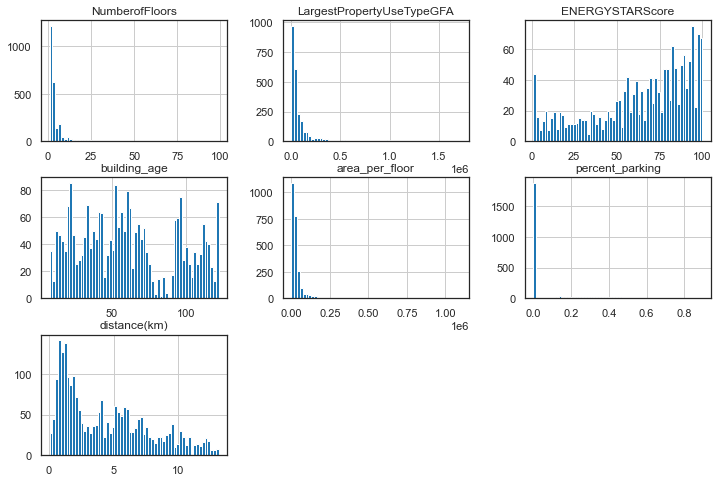

In [27]:
x_train[numerical_features].hist(figsize=(12, 8), bins=60)
plt.subplots_adjust()
to_png('feature_skew')


#### La distribution des variables cibles


array([[<AxesSubplot:title={'center':'SiteEnergyUse(kBtu)'}>,
        <AxesSubplot:title={'center':'TotalGHGEmissions'}>]], dtype=object)

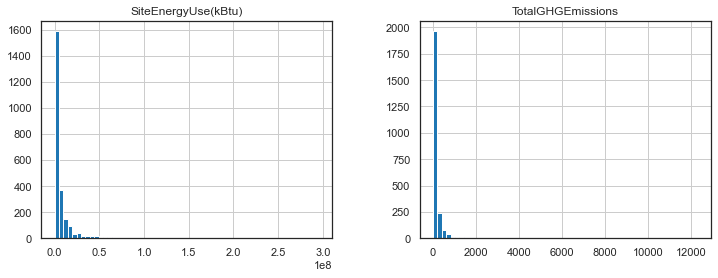

In [28]:
y_train.hist(figsize=(12, 4), bins=60)


In [29]:
display(x_train[numerical_features].skew())
display(y.skew())


NumberofFloors               6.191799
LargestPropertyUseTypeGFA    5.483106
ENERGYSTARScore             -0.697412
building_age                 0.294093
area_per_floor               9.298406
percent_parking              2.321009
distance(km)                 0.693190
dtype: float64

SiteEnergyUse(kBtu)     9.310386
TotalGHGEmissions      13.456892
dtype: float64

#### Normalisation des distributions assymétriques

Les distributions sont très assymétrique (skew > 0.5), sauf `building_age`.

Les outliers (par exemple, très grand surface, très haut consommation energetique) vont avoir trop de poids sur la régression, car la plupart des algorithmes de régression suppose que les distributions des erreurs des residuels des variables sont symmétriques et approximativement normale

Pour réduir les skew positives, les transformations suivants sont testés :

- racine carrée
- transformation log
- transformation [box-cox](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer)

(La transformation yeo-johnson est un alternative à Box-Cox quand les variables contient des valeurs negatives)

Pour réduire le skew negative d'ENERGYSTARScore, la transformation carré est testé :


On regarde d'abord l'asymetrie (skew) des distributions produites par les transformations


In [30]:
from scipy.stats import boxcox


def transform_skew(df, cols):
    y_transforms = df[cols].skew().to_frame(name='feature.skew()')
    y_transforms['square'] = np.power(df[cols], 2).skew()
    y_transforms['sqrt'] = np.sqrt(df[cols]).skew()
    y_transforms['log'] = np.log1p(df[cols]).skew()
    boxcox_df = pd.DataFrame()
    for col in cols:
        boxcox_df[col], lambda_ = boxcox(df[col]+0.01)
    y_transforms['box-cox'] = boxcox_df.skew()
    return y_transforms


print('skew pour les variables après divers transformations')
abs(transform_skew(x_train, numerical_features)
    ).style.background_gradient(axis=1).highlight_min(axis=1)


skew pour les variables après divers transformations


,feature.skew(),square,sqrt,log,box-cox
NumberofFloors,6.191799,16.397228,2.834903,1.407401,0.082522
LargestPropertyUseTypeGFA,5.483106,10.634616,2.717860,0.883371,0.035920
ENERGYSTARScore,0.697412,0.053398,1.306566,2.227675,1.401066
building_age,0.294093,0.875420,0.132441,0.647927,0.114049
area_per_floor,9.298406,36.156056,2.789375,0.530941,0.087020
percent_parking,2.321009,4.707324,1.655831,2.084854,1.391496
distance(km),0.693190,1.566087,0.169471,0.080303,0.095657


La transformation Box-Cox produit les distributions plus symmetrique

#### Visualisation des distributions produites par chaque transformation


SiteEnergyUse(kBtu) (skew=9.57) : p=0.000, Normality = False
sqrt(SiteEnergyUse(kBtu)) (skew=3.22) : p=0.000, Normality = False
log(SiteEnergyUse(kBtu)) (skew=0.29) : p=0.000, Normality = False
boxcox(SiteEnergyUse(kBtu)) (skew=-0.01) : p=0.008, Normality = False
Box-Cox transform, lambda = -0.06790251736370403


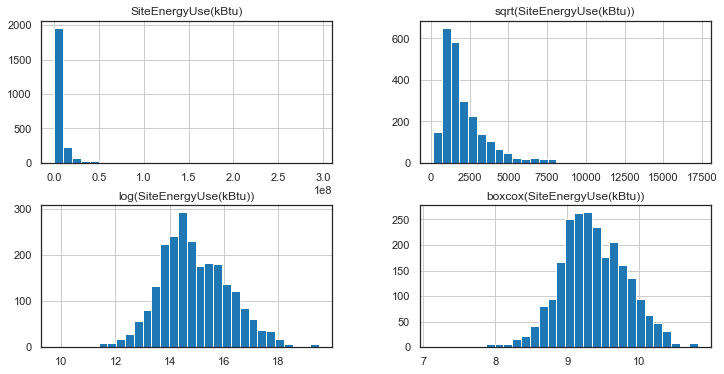

TotalGHGEmissions (skew=13.24) : p=0.000, Normality = False
sqrt(TotalGHGEmissions) (skew=4.25) : p=0.000, Normality = False
log(TotalGHGEmissions) (skew=0.22) : p=0.000, Normality = False
boxcox(TotalGHGEmissions) (skew=-0.00) : p=0.001, Normality = False
Box-Cox transform, lambda = -0.0006407330107840109


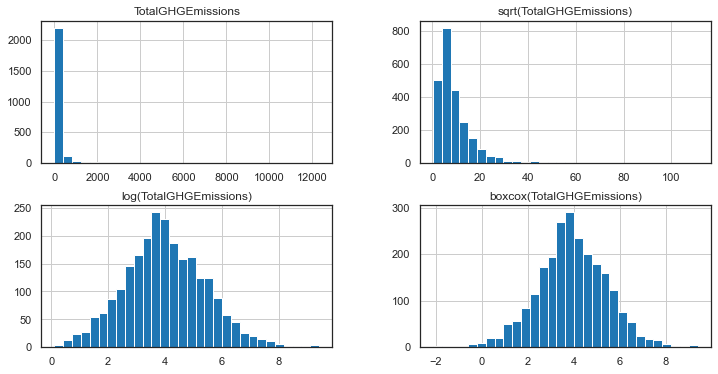

LargestPropertyUseTypeGFA (skew=5.48) : p=0.000, Normality = False
sqrt(LargestPropertyUseTypeGFA) (skew=2.72) : p=0.000, Normality = False
log(LargestPropertyUseTypeGFA) (skew=0.88) : p=0.000, Normality = False
boxcox(LargestPropertyUseTypeGFA) (skew=0.04) : p=0.123, Normality = True
Box-Cox transform, lambda = -0.33237611788815075


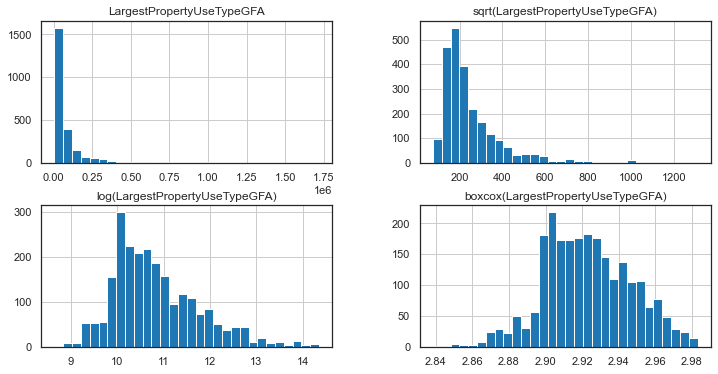

In [31]:
from scipy.stats import boxcox, normaltest


def plot_transforms(df, col='SiteEnergyUse(kBtu)'):
    y_transforms = df[[col]].copy()
    y_transforms[f'sqrt({col})'] = np.sqrt(df[col])
    y_transforms[f'log({col})'] = np.log1p(df[col])
    y_transforms[f'boxcox({col})'], lambda_ = boxcox(df[col]+0.001)
    for col in y_transforms:
        skew = y_transforms[col].skew()
        stats, p = normaltest(y_transforms[col].dropna())
        normality = (p > 0.05)
        print(f'{col} (skew={skew:.2f}) : p={p:.3f}, Normality = {normality}')
    print(f'Box-Cox transform, lambda = {lambda_}')
    y_transforms.hist(figsize=(12, 6), bins=30)
    plt.subplots_adjust()


plot_transforms(y_train, 'SiteEnergyUse(kBtu)')
plt.show()
plot_transforms(y_train, 'TotalGHGEmissions')
plt.show()
plot_transforms(x_train, 'LargestPropertyUseTypeGFA')
plt.show()


La transformation box-cox fourni les distributions plus proche à la distribution normale.

Néanmoins, les valeurs de lambda sont proche à zero:

La transformation `coxbox(x) = (x** lambda - 1) / lambda`

Quand lambda est [proche de zero, la transformation Cox-Box est approximativement égal à log(x)](https://towardsdatascience.com/box-cox-transformation-is-the-magic-we-need-3d0ef9a18339)

Donc, on favorise la transformation log

- pour simplifier la preprocessing
- pour faciliter l'interpretabilité des résultats


#### Transformation des variables x et cibles y

On essaie de reduire le skew avec un transformation log fait que les valeurs sont toutes de la même ordre de magnitude

Pour n'avoir pas des problèmes des valeurs x <= 0 :

- utiliser la fonction `np.log1p` = log(1+X) (ou X >=0)
- appliquer la transformation log sur les données unscaled (x_train > 0); ou
- appliquer la transformation log sur les données mis à l'echelle avec MinMaxScalar (0 < x_train < 1)


In [32]:
from sklearn.preprocessing import FunctionTransformer

# def transform_numeric_variables(xtrain,ytrain,xtest,ytest):
log_features = []
log_transformer = FunctionTransformer(
    func=np.log1p, inverse_func=np.expm1, validate=True)

x_train_num = x_train_imputed[numerical_features]
log_x_train_num = log_transformer.fit_transform(x_train_num.values)
log_x_train_num = pd.DataFrame(
    log_x_train_num, index=x_train.index, columns=numerical_features)

feature_skew = x_train_num.skew()
log_feature_skew = log_x_train_num.skew()

(pd.concat([feature_skew, log_feature_skew], axis=1)
 .rename(columns={0: 'feature.skew()', 1: 'log(feature).skew()'})
 ).style.highlight_min(axis=1)


,feature.skew(),log(feature).skew()
NumberofFloors,6.191799,1.407401
LargestPropertyUseTypeGFA,5.483106,0.883371
ENERGYSTARScore,-1.124963,-2.971158
building_age,0.294093,-0.647927
area_per_floor,9.298406,0.530941
percent_parking,2.321009,2.084854
distance(km),0.693190,-0.080303


La transformation `np.log1p` a un effet de réduction de skew (absolute) de toutes les variables numériques sauf `building_age`.


#### Corrélations avec les variables cibles :


In [33]:
def correlations_entre_X_et_y(x, y, target_feature='SiteEnergyUse(kBtu)'):
    """créer un table de corrélations entre x, log(x), y et log(y)"""
    log_target_feature = f'log_{target_feature}'
    log_x = pd.DataFrame(np.log1p(x), index=x.index, columns=x.columns)
    log_y = np.log1p(y[target_feature]).rename(log_target_feature)
    x_corr_y = pd.concat([x, y], axis=1).corr()[target_feature]
    x_corr_log_y = pd.concat([x, log_y], axis=1).corr()[log_target_feature]
    log_x_corr_y = pd.concat([log_x, y], axis=1).corr()[target_feature]
    log_x_corr_log_y = pd.concat([log_x, log_y], axis=1).corr()[
        log_target_feature]
    cible_corr = np.abs(
        pd.concat([x_corr_y, log_x_corr_y, x_corr_log_y, log_x_corr_log_y], axis=1))
    cible_corr.columns = ['x.corr(y)', 'log_x.corr(y)',
                          'x.corr(log_y)', 'log_x.corr(log_y)']
    return cible_corr


(correlations_entre_X_et_y(x_train[numerical_features], y_train, target_feature='SiteEnergyUse(kBtu)')
 .style.background_gradient(axis=1))


,x.corr(y),log_x.corr(y),x.corr(log_y),log_x.corr(log_y)
NumberofFloors,0.366474,0.374444,0.412469,0.514166
LargestPropertyUseTypeGFA,0.696644,0.534514,0.589931,0.728582
ENERGYSTARScore,0.059152,0.048542,0.162465,0.149496
building_age,0.151976,0.154623,0.263605,0.287917
area_per_floor,0.297409,0.248659,0.291108,0.310469
percent_parking,0.089465,0.093734,0.294092,0.301741
distance(km),0.155053,0.185895,0.244239,0.297501
SiteEnergyUse(kBtu),1.000000,1.000000,nan,nan
TotalGHGEmissions,0.889964,0.889964,nan,nan
log_SiteEnergyUse(kBtu),nan,nan,1.000000,1.000000


In [34]:
(correlations_entre_X_et_y(x_train[numerical_features], y_train, target_feature='TotalGHGEmissions')
 .style.background_gradient(axis=1))


,x.corr(y),log_x.corr(y),x.corr(log_y),log_x.corr(log_y)
NumberofFloors,0.185978,0.228726,0.306808,0.376427
LargestPropertyUseTypeGFA,0.583666,0.401802,0.495512,0.593567
ENERGYSTARScore,0.093208,0.066465,0.153620,0.138707
building_age,0.087412,0.088327,0.159594,0.174788
area_per_floor,0.281318,0.228173,0.288136,0.304617
percent_parking,0.012082,0.013252,0.153373,0.156886
distance(km),0.096708,0.115182,0.166185,0.220152
SiteEnergyUse(kBtu),0.889964,0.889964,nan,nan
TotalGHGEmissions,1.000000,1.000000,nan,nan
log_TotalGHGEmissions,nan,nan,1.000000,1.000000


La correlation entre les variables **x** et la cible **y** est le plus fort apres log transformation des variables x et cibles y

La transformation de toutes les variables numériques par log a l'effet de :

- reduire le skew, sauf pour building_age (les distributions sont plus proche à la distribution normale)
- reduire l'influence des outliers
- augmenter les correlations

Le building age et l'ENERGYSTARScore ont u meilleur correlation sans transformation log

La variable 'percent_parking' reste très assymétrique et problematique : On change pour une variable binaire


### Transformation des variables numériques


In [35]:
def transform_variables(x_orig, y):
    """Faire du logarithme sur tous les variables numériques, sauf 'ENERGYSTARScore' et 'building_age'"""
    x = x_orig.copy()
    for col in x.select_dtypes('number').columns:
        if not col in ['ENERGYSTARScore', 'building_age']:
            x[col] = np.log1p(x[col])
            x = x.rename(columns={col: f'log({col})'})
    log_y = pd.DataFrame(np.log1p(y), index=y.index, columns=y.columns)
    for col in log_y.columns:
        log_y = log_y.rename(columns={col: f'log({col})'})
    return x, log_y


x_train_transformed, y_train_transformed = transform_variables(
    x_train, y_train)
x_test_transformed, y_test_transformed = transform_variables(x_test, y_test)

display(x_train_transformed.describe())
display(y_train_transformed.describe())


,log(NumberofFloors),log(LargestPropertyUseTypeGFA),ENERGYSTARScore,building_age,log(area_per_floor),log(percent_parking),log(distance(km))
count,2388.000000,2388.000000,1590.000000,2388.000000,2388.000000,2388.000000,2388.000000
mean,1.364326,10.834453,63.867296,60.902429,9.967500,0.055272,1.486229
std,0.649277,0.949786,28.446509,32.595323,0.795648,0.117304,0.663115
min,0.693147,8.640649,1.000000,8.000000,5.405812,0.000000,0.055842
25%,0.693147,10.147296,46.000000,34.000000,9.386183,0.000000,0.880196
50%,1.098612,10.649961,71.000000,57.000000,9.930410,0.000000,1.568004
75%,1.609438,11.391243,88.000000,93.000000,10.404445,0.000000,2.046141
max,4.605170,14.357628,100.000000,122.000000,13.910822,0.639231,2.649002


,log(SiteEnergyUse(kBtu)),log(TotalGHGEmissions)
count,2388.000000,2388.000000
mean,14.914320,3.994416
std,1.296665,1.430937
min,9.749812,0.113329
25%,14.020146,3.043212
50%,14.777009,3.916314
75%,15.762157,4.934059
max,19.505237,9.418018


#### Visualisation des rélations apres transformation

Relations des variables X transformés avec les variables à prédire (par 'PrimaryUseType')


Index(['DataYear', 'log(NumberofFloors)', 'log(LargestPropertyUseTypeGFA)',
       'ZipCode', 'ENERGYSTARScore', 'PrimaryUseType', 'building_age',
       'log(area_per_floor)', 'log(percent_parking)', 'log(distance(km))',
       'log(SiteEnergyUse(kBtu))', 'log(TotalGHGEmissions)'],
      dtype='object')


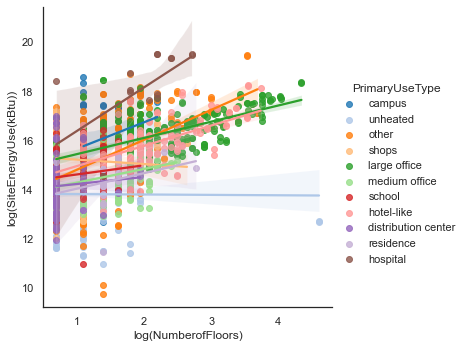

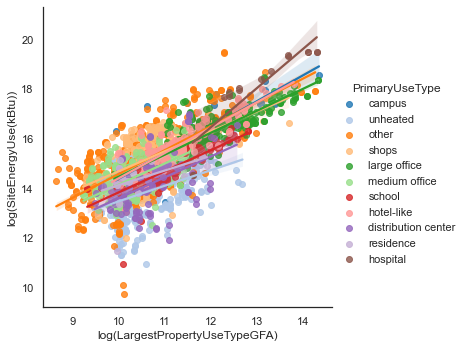

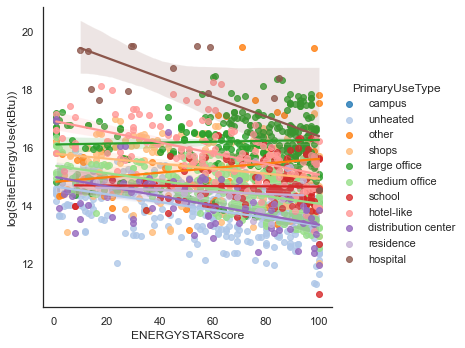

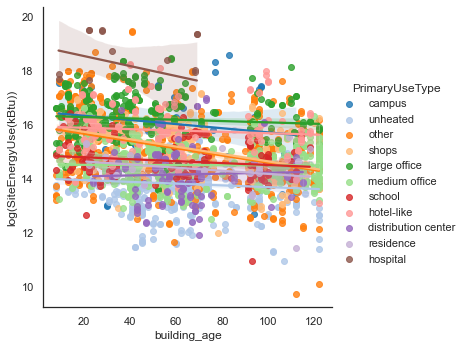

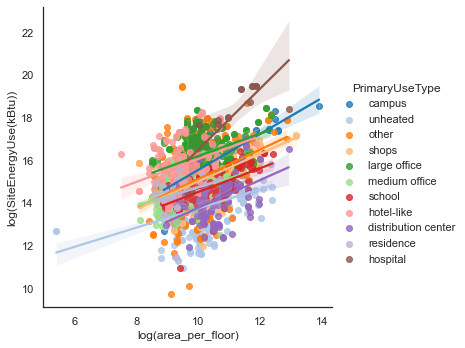

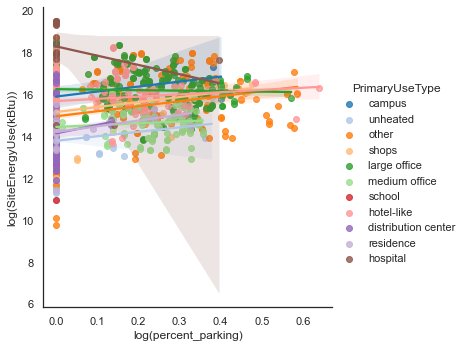

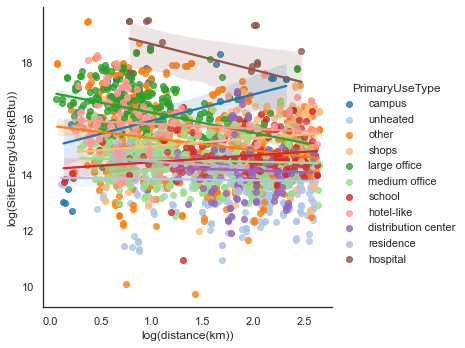

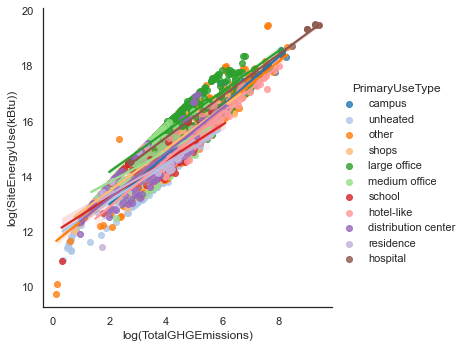

In [36]:
def plot_x_y(df, yvar='SiteEnergyUse(kBtu)', hue=None):
    print(df.columns)
    for col in df.select_dtypes('number'):
        if col != yvar:
            sns.lmplot(data=df, x=col, y=yvar, hue=hue)
            plt.show()


x_y_transformed = pd.concat([x_train_transformed, y_train_transformed], axis=1)
log_target_feature = 'log(SiteEnergyUse(kBtu))'


# x_y_transformed.head()
plot_x_y(x_y_transformed, yvar='log(SiteEnergyUse(kBtu))', hue='PrimaryUseType')


Certains des variables transformés semble avoir des correlations dépendent du PrimaryUseType : peut-être il faut créer des régressions individuels par PrimaryUseType ?


#### Scaling

Il faut mettre les variables numériques à la même échelle pour qu'ils ont la même poids sur la regréssion, et que le descente de gradient utilisé dans la plupart des modèles est plus rapide.

Il y a plusieurs scalers possible

- **StandardScaler** : x_scaled = (x - moyenne(x)/ écart_type(x)) (attention: ça produit des valeurs négatifs)
- **MinMaxScaler** : x_scaled = (x - min_x)/(max_x - min_x) (valeurs entre 0 et 1)
- **RobustScaler** : x_scaled = (x - médian(x))/InterQuartileRange(x)

Scale avant log transformation:

- subtraction de la moyenne = dificil d'intérpréter
- division par écart_type == déplace par log(écart_type)

Scale après log transformation:

- subtraction de la moyenne == divisé par la constant `exp(moyenne)`
- division par l'écart_type == réduire la puissance polynomial du log

Exemple: log(x)/2 == log(sqrt(x))
log(x)\*2 = log(x\*\*2)


##### Scale après transformation des colonnes

Pour n'avoir pas des problèmes des valeurs x <= 0 :

- appliquer la transformation log sur les valeurs des données (x_train > 0) ou utiliser MinMaxScalar (0 < x_train < 1)
- utiliser la fonction `np.log1p` = log(1+X)


In [37]:
from sklearn.preprocessing import StandardScaler


def scale_columns(df, cols=None, scaler=None):
    df = df.copy()
    if cols is None:
        cols = df.select_dtypes('number').columns
    if scaler is None:
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df[cols])
    else:
        scaled = scaler.transform(df[cols])
    scaled_df = pd.DataFrame(scaled, index=df.index,
                             columns=scaler.get_feature_names_out())
    for col in df[cols]:
        df[col] = scaled_df[col]
    return df


scaler = StandardScaler()
numerical_features = x_train_transformed.select_dtypes('number').columns
print(numerical_features)

scaler.fit(x_train_transformed[numerical_features])
x_train_scaled = scale_columns(x_train_transformed, numerical_features, scaler)
x_test_scaled = scale_columns(x_test_transformed, numerical_features, scaler)

std_df = pd.concat([x_train_transformed[numerical_features].std(),
                    x_train_scaled[numerical_features].std(),
                   x_test_scaled[numerical_features].std()], axis=1)
std_df.columns = [
    'x_train_transformed.std()', 'x_train_scaled.std()', 'x_test_scaled.std()']
std_df


Index(['log(NumberofFloors)', 'log(LargestPropertyUseTypeGFA)',
       'ENERGYSTARScore', 'building_age', 'log(area_per_floor)',
       'log(percent_parking)', 'log(distance(km))'],
      dtype='object')


,x_train_transformed.std(),x_train_scaled.std(),x_test_scaled.std()
log(NumberofFloors),0.649277,1.000209,1.007508
log(LargestPropertyUseTypeGFA),0.949786,1.000209,0.994080
ENERGYSTARScore,28.446509,1.000315,1.020399
building_age,32.595323,1.000209,1.010798
log(area_per_floor),0.795648,1.000209,0.939036
log(percent_parking),0.117304,1.000209,0.993760
log(distance(km)),0.663115,1.000209,1.026494


#### Verification d'indépendence des features numériques après preprocessing


In [38]:
from sklearn.linear_model import LinearRegression


def calculate_vif(df, features=None):
    """
    Calculate Variance Inflation Factor (VIF) for each feature
    modified version from original at
    https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f
     """
    if features is None:
        features = df.select_dtypes(include='number').columns
    features = sorted(
        set(features) - {'SiteEnergyUse(kBtu)', 'TotalGHGEmissions'})
    vif, tolerance = {}, {}
    df = df[features].dropna()
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        x = [f for f in features if f != feature]
        x, y = df[x], df[feature]
        # extract r-squared from the fit
        model = LinearRegression().fit(x, y)
        r2 = model.score(x, y)
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1 / (tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})


print(calculate_vif(x_train))
calculate_vif(x_train_transformed)


                                VIF  Tolerance
ENERGYSTARScore            1.026513   0.974172
LargestPropertyUseTypeGFA  2.569925   0.389116
NumberofFloors             2.363888   0.423032
area_per_floor             1.499234   0.667007
building_age               1.354453   0.738305
distance(km)               1.398898   0.714849
percent_parking            1.357409   0.736698


,VIF,Tolerance
ENERGYSTARScore,1.048671,0.953588
building_age,1.398458,0.715074
log(LargestPropertyUseTypeGFA),13.099847,0.076337
log(NumberofFloors),13.129659,0.076163
log(area_per_floor),9.345105,0.107008
log(distance(km)),1.877050,0.532751
log(percent_parking),1.549445,0.645392


Le log transformation a introduit des colinearités, qui peut augmenter les erreurs.

Si besoin, on peut réduire la colinéarité entre log(LargestPropertyUseTypeGFA), log(NumberofFloors) et log(area_per_floor) en supprimant la variable qui a le plus de skew (NumberofFloors)


In [39]:
calculate_vif(x_train_transformed.drop('log(NumberofFloors)', axis=1))


,VIF,Tolerance
ENERGYSTARScore,1.047816,0.954366
building_age,1.392588,0.718088
log(LargestPropertyUseTypeGFA),1.993804,0.501554
log(area_per_floor),1.775683,0.563163
log(distance(km)),1.720198,0.581328
log(percent_parking),1.468670,0.680888


### Feature engineering:

- pour éliminer colinéarités : transform variable numérique `NumberofFloors` en catégorie ordinal `building_rise`
- transform `percent_parking` (très assymetrique) en booléen `has_parking`
- reduire nombre de catégories `ZipCode` au top N + 'other'


In [40]:
def create_building_rise(df):

    def category_rise(floors: int):
        if floors < 5:
            return '(1-4) LR Low Rise'
        elif (floors < 10):
            return '(5-9) MR Mid Rise'
        else:
            return '(10+) HR High Rise'

    if not 'NumberofFloors' in df.columns:
        return df
    df = df.copy()
    df['building_rise'] = df['NumberofFloors'].map(category_rise)
    return df.drop('NumberofFloors', axis=1)


x_train = create_building_rise(x_train)


In [41]:
def create_has_parking(df):
    if not 'percent_parking' in df.columns:
        return df
    df = df.copy()
    df['has_parking'] = df['percent_parking'] > 0
    return df.drop('percent_parking', axis=1)


x_train = create_has_parking(x_train)


In [42]:
def get_top_n(series: pd.Series, nb=10, exclude_other=True):
    counts = series.value_counts()
    if exclude_other:
        if 'other' in counts.index:
            counts = counts.drop('other')
    nb = min(len(counts), nb)
    return list(counts.head(nb).index)


def simplifier_zip_code(df, top_n=None, nb=10):
    if not 'ZipCode' in df.columns:
        return df
    df = df.copy()
    df['ZipCode'] = df['ZipCode'].astype(str)
    if top_n is None:
        top_n = get_top_n(df['ZipCode'])
    mask = df['ZipCode'].isin(top_n)
    df.loc[~mask, 'ZipCode'] = 'other'
    return df


top_n = get_top_n(x_train['ZipCode'])
x_train = simplifier_zip_code(x_train, top_n)
x_test = simplifier_zip_code(x_test, top_n)
x_test['ZipCode'].value_counts()


other    598
Name: ZipCode, dtype: int64

In [43]:
def drop_building_id(df):
    if 'OSEBuildingID' in df.columns:
        return df.drop(columns='OSEBuildingID')
    else:
        return df


### Pipeline de preprocessing

On utilise les mêmes colonnes et preprocessor pour comparer les algorithmes


In [44]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder, OneHotEncoder

print(x_train.columns)


def split_features(df):
    numerical_features = df.select_dtypes('number').columns.tolist()
    feature_skew = df[numerical_features].skew()
    scale_features = feature_skew[feature_skew < 0.5].index.tolist()
    log_features = list(set(numerical_features)-set(scale_features))
    ordinal_features = ['building_rise']
    category_features = (x_train.pipe(drop_building_id)
                         .drop(columns=ordinal_features)
                         .select_dtypes(exclude='number').columns.tolist())
    print(f'scale_features : {scale_features}')
    print(f'log_features : {log_features}')
    print(f'ordinal_features : {ordinal_features}')
    print(f'category_features : {category_features}')
    return scale_features, log_features, ordinal_features, category_features


scale_features, log_features, ordinal_features, category_features = split_features(
    x_train)

# ENERGYSTARScore, building_age, (abs(skew) < 0.5)
scale_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale', StandardScaler())
])

# les autres variables numériques
log_scale_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log', FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)),
    ('scale', StandardScaler()),
])

ordinal_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    # ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
    ('ord', OrdinalEncoder())
])

category_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('simple_scale', scale_transformer, scale_features),
        ('log_scale', log_scale_transformer, log_features),
        ('categ', category_transformer, category_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ],
    remainder='drop'
)


Index(['DataYear', 'LargestPropertyUseTypeGFA', 'ZipCode', 'ENERGYSTARScore',
       'PrimaryUseType', 'building_age', 'area_per_floor', 'distance(km)',
       'building_rise', 'has_parking'],
      dtype='object')
scale_features : ['ENERGYSTARScore', 'building_age']
log_features : ['distance(km)', 'LargestPropertyUseTypeGFA', 'area_per_floor']
ordinal_features : ['building_rise']
category_features : ['DataYear', 'ZipCode', 'PrimaryUseType', 'has_parking']


#### Visualise le preprocessor


In [45]:
from sklearn import set_config
set_config(display='diagram')
# displays HTML representation in a jupyter context
preprocessor


ColumnTransformer(transformers=[('simple_scale',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 ['ENERGYSTARScore', 'building_age']),
                                ('log_scale',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>,
                                                                      validate=True)),
                                                 ('scale', StandardScaler())]),
                                 ['distance(km)', 'LargestPropertyUseTypeGFA',
                                  'area_per_floor']),
                                ('categ',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['DataYear', 'ZipCode', 'PrimaryUseType',
                                  'has_parking']),
                                ('ordinal',
                                 Pipeline(steps=[('ord', OrdinalEncoder())]),
                                 ['building_rise'])])

## Transformation des données nettoyés en jeux d'entrainement et test

Ci-dessous, la pipeline pour converti les données


In [46]:
model_df = (model_df.pipe(create_building_rise)
            .pipe(create_has_parking)
            .pipe(simplifier_zip_code)
            .pipe(drop_building_id))

colonnes_cibles = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
colonnes_x = model_df.drop(colonnes_cibles, axis=1).columns


x, y = create_x_y(model_df, cols_x=colonnes_x, col_y=colonnes_cibles)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=x['PrimaryUseType'], random_state=1)

scale_features, log_features, ordinal_features, category_features = split_features(
    x_train)
numerical_features = scale_features+log_features
pipe = Pipeline(steps=[('preprocessor', preprocessor)])
pipe.verbose = True

# Select features to transform
# ColumnTransformer returns columns in order of transformation
x_train_selected = x_train[scale_features +
                           log_features + ordinal_features + category_features]
x_test_selected = x_test[scale_features +
                         log_features + ordinal_features + category_features]

x_train_model = pipe.fit_transform(x_train_selected)
x_test_model = pipe.transform(x_test_selected)
x_train_model.shape

category_transformer.fit(x_train[category_features].values)
categ_features = category_transformer.get_feature_names_out(category_features)
print(f'categ_features : {categ_features}')

transformed_columns = list(scale_features) + list(log_features) + \
    list(ordinal_features)+list(categ_features)


x_train_df = pd.DataFrame(x_train_model, index=x_train_selected.index,
                          columns=transformed_columns)
x_train_df[numerical_features] = x_train_df[numerical_features].astype(float)


x_test_df = pd.DataFrame(x_test_model, index=x_test_selected.index,
                         columns=transformed_columns)
x_test_df[numerical_features] = x_test_df[numerical_features].astype(float)

x_train_df.head()


create_x_y, y=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], x=['DataYear', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'ZipCode', 'PrimaryUseType', 'building_age', 'area_per_floor', 'distance(km)', 'building_rise', 'has_parking']
scale_features : ['ENERGYSTARScore', 'building_age']
log_features : ['distance(km)', 'LargestPropertyUseTypeGFA', 'area_per_floor']
ordinal_features : ['building_rise']
category_features : ['DataYear', 'ZipCode', 'PrimaryUseType', 'has_parking']
[Pipeline] ...... (step 1 of 1) Processing preprocessor, total=   0.0s
categ_features : ['DataYear_2016' 'ZipCode_98103' 'ZipCode_98104' 'ZipCode_98105'
 'ZipCode_98108' 'ZipCode_98109' 'ZipCode_98119' 'ZipCode_98121'
 'ZipCode_98122' 'ZipCode_98134' 'ZipCode_other'
 'PrimaryUseType_distribution center' 'PrimaryUseType_hospital'
 'PrimaryUseType_hotel-like' 'PrimaryUseType_large office'
 'PrimaryUseType_medium office' 'PrimaryUseType_other'
 'PrimaryUseType_residence' 'PrimaryUseType_school' 'PrimaryUseType_shops'


C:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  "X does not have valid feature names, but"


,ENERGYSTARScore,building_age,distance(km),LargestPropertyUseTypeGFA,area_per_floor,building_rise,DataYear_2016,ZipCode_98103,ZipCode_98104,ZipCode_98105,ZipCode_98108,ZipCode_98109,ZipCode_98119,ZipCode_98121,ZipCode_98122,ZipCode_98134,ZipCode_other,PrimaryUseType_distribution center,PrimaryUseType_hospital,PrimaryUseType_hotel-like,PrimaryUseType_large office,PrimaryUseType_medium office,PrimaryUseType_other,PrimaryUseType_residence,PrimaryUseType_school,PrimaryUseType_shops,PrimaryUseType_unheated,has_parking_True
2073,NaN,-0.395920,-0.183595,0.852485,0.364804,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2608,NaN,-0.856205,-0.032245,-0.833528,0.137837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
820,NaN,-0.089063,-1.510563,0.031605,-0.690388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1827,-0.276652,-0.702776,1.677420,1.104160,2.407914,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1949,-0.206322,-1.439233,-1.130187,1.451605,0.061803,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


# 3. Prédiction de la consommation énergétique


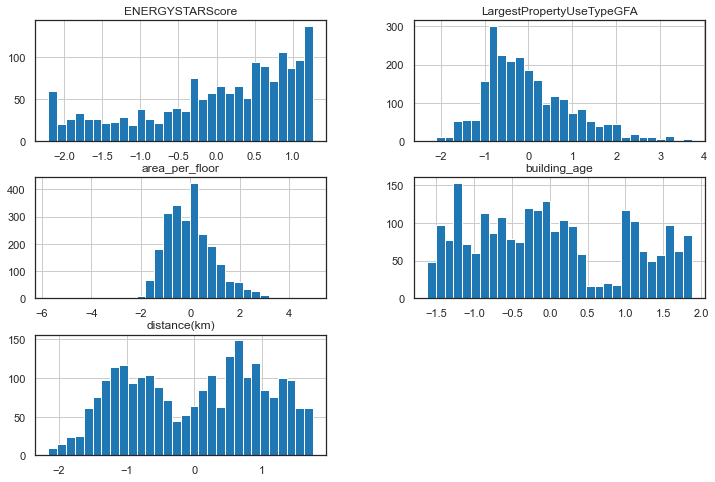

In [47]:


x_train_df[scale_features + log_features].sort_index(
    axis=1).hist(figsize=(12, 8), bins=30)
plt.show()


## Modèle baseline (dummyRegressor)


## Modèle linéaire


## Modèle non-linéaire


## Modèle ensembliste


## Évaluation des prédictions (analyse d'erreurs)


## Comparaison et choix du modèle


# 4. Prédiction des émissions CO2


# 5. Influence de l'ENERGYSTARScore sur les prédictions


# 6. Résultats

## Comparaison des performances des modèles


# 7. Conclusion
